In [1]:
n_threads = 6

In [2]:
import os
if n_threads is not None:
    os.environ["OMP_NUM_THREADS"] = str(n_threads)

In [3]:
import sys
import yaml
import warnings
warnings.filterwarnings("ignore")

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gpytorch.means import ConstantMean

from xopt import Xopt, VOCS
from xopt.evaluator import Evaluator
from xopt.numerical_optimizer import LBFGSOptimizer
from xopt.generators import UpperConfidenceBoundGenerator, ExpectedImprovementGenerator
from xopt.generators.bayesian.models.standard import StandardModelConstructor
from lume_model.utils import variables_from_yaml
from lume_model.torch import LUMEModule, PyTorchModel

from utils import display_model
sys.path.append("calibration/calibration_modules/")
from decoupled_linear import OutputOffset, OutputScale, DecoupledLinearOutput

## Define VOCS

In [4]:
filename = "../variables.csv"
VARIABLE_RANGES = pd.read_csv(filename, index_col=0, header=None).T.to_dict(orient='list')
VARIABLES = ["SOLN:IN20:121:BCTRL", "QUAD:IN20:121:BCTRL", "QUAD:IN20:122:BCTRL",
             "QUAD:IN20:361:BCTRL", "QUAD:IN20:371:BCTRL", "QUAD:IN20:425:BCTRL",
             "QUAD:IN20:441:BCTRL", "QUAD:IN20:511:BCTRL", "QUAD:IN20:525:BCTRL"]
vocs = VOCS(
    variables = {ele: VARIABLE_RANGES[ele] for ele in VARIABLES},
    objectives = {"total_size": "MINIMIZE"},
    constraints = {"c1": ["LESS_THAN", 0.0]},
)
print(vocs.as_yaml())

variables:
  SOLN:IN20:121:BCTRL: [0.377, 0.498]
  QUAD:IN20:121:BCTRL: [-0.021, 0.021]
  QUAD:IN20:122:BCTRL: [-0.021, 0.021]
  QUAD:IN20:361:BCTRL: [-4.32, -1.08]
  QUAD:IN20:371:BCTRL: [1.09, 4.31]
  QUAD:IN20:425:BCTRL: [-7.56, -1.08]
  QUAD:IN20:441:BCTRL: [-1.08, 7.56]
  QUAD:IN20:511:BCTRL: [-1.08, 7.56]
  QUAD:IN20:525:BCTRL: [-7.56, -1.08]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Define NN prior

In [5]:
model_path = "lcls_cu_injector_nn_model/"

# load sim_to_nn transformers
input_sim_to_nn = torch.load(model_path + "model/input_sim_to_nn.pt")
output_sim_to_nn = torch.load(model_path + "model/output_sim_to_nn.pt")

# load pv_to_sim transformers
input_pv_to_sim = torch.load(model_path + "model/input_pv_to_sim.pt")
output_pv_to_sim = torch.load(model_path + "model/output_pv_to_sim.pt")

# load in- and output variable specification
input_variables, output_variables = variables_from_yaml(open(model_path + "model/pv_variables.yml"))

# replace keys in input variables
input_variables = {name.replace("BACT", "BCTRL"): ele for name, ele in input_variables.items()}

# create LUME-model
lume_model = PyTorchModel(
    model_file=model_path + "model/model.pt",
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_pv_to_sim, input_sim_to_nn],
    output_transformers=[output_sim_to_nn, output_pv_to_sim],
)

# wrap in LUMEModule
lume_module = LUMEModule(
    model=lume_model,
    feature_order=vocs.variable_names,
    output_order=lume_model.outputs[0:2],
)

# define objective model
class ObjectiveModel(torch.nn.Module):
    def __init__(self, model: LUMEModule):
        super(ObjectiveModel, self).__init__()
        self.model = model

    @staticmethod
    def function(sigma_x: torch.Tensor, sigma_y: torch.Tensor) -> torch.Tensor:
        # using this calculation due to occasional negative values
        sigma_xy = torch.sqrt(sigma_x ** 2 + sigma_y ** 2)
        # roundness = torch.abs(sigma_x - sigma_y)
        return sigma_xy / 1e3  # + roundness

    def forward(self, x) -> torch.Tensor:
        idx_sigma_x = self.model.output_order.index("OTRS:IN20:571:XRMS")
        idx_sigma_y = self.model.output_order.index("OTRS:IN20:571:YRMS")
        sigma_x = self.model(x)[..., idx_sigma_x]
        sigma_y = self.model(x)[..., idx_sigma_y]
        return self.function(sigma_x, sigma_y)


objective_model = ObjectiveModel(lume_module)

In [6]:
# define miscalibrated objective model
y_size = len(vocs.objective_names)
y_offset = -0.5 * torch.ones(y_size)
y_scale = torch.ones(y_size)

miscal_model = DecoupledLinearOutput(
    model=objective_model,
    y_offset_initial=y_offset,
    y_scale_initial=y_scale,
)
miscal_model.requires_grad_(False);

In [7]:
# define custom mean
custom_mean = OutputOffset(
    model=miscal_model,
)

## Define evaluate function

In [8]:
def get_model_predictions(input_dict, generator = None):
    output_dict = {}
    for output_name in generator.vocs.output_names:
        if generator is not None and generator.model is not None:
            gp = generator.model.models[generator.vocs.output_names.index(output_name)]
            x = torch.tensor([input_dict[k] for k in generator.vocs.variable_names], dtype=torch.double).unsqueeze(0)
            with torch.no_grad():
                _x = gp.input_transform.transform(x)
                _x = gp.mean_module(_x)
                prior_mean = gp.outcome_transform.untransform(_x)[0].item()
                posterior = gp.posterior(x)
                posterior_mean = posterior.mean.item()
                posterior_sd = torch.sqrt(posterior.mvn.variance).item()
        else:
            prior_mean, posterior_mean, posterior_sd = np.nan, np.nan, np.nan
    
        output_dict[output_name + "_prior_mean"] = prior_mean
        output_dict[output_name + "_posterior_mean"] = posterior_mean
        output_dict[output_name + "_posterior_sd"] = posterior_sd
    return output_dict

In [9]:
# Xopt evaluator function
def evaluate(input_dict, generator = None):
    model_result = lume_model.evaluate(input_dict)
    sigma_xy = objective_model.function(model_result["OTRS:IN20:571:XRMS"], model_result["OTRS:IN20:571:YRMS"])
    output_dict = {vocs.objective_names[0]: sigma_xy.detach().item()}
    
    # dummy constraint
    output_dict["c1"] = output_dict[vocs.objective_names[0]] - 1.0

    # GP model predictions
    model_predictions = get_model_predictions(input_dict, generator)
    output_dict.update(model_predictions)
    
    return output_dict

## Restrict ranges based on profile monitor

In [10]:
vocs.variables = {k: input_variables[k].value_range for k in vocs.variable_names}
vocs.variables["SOLN:IN20:121:BCTRL"] = [0.467, 0.479]
print(vocs.as_yaml())

variables:
  QUAD:IN20:121:BCTRL: [-0.02098429469554406, 0.020999198106589838]
  QUAD:IN20:122:BCTRL: [-0.020998830517503037, 0.020998929132148195]
  QUAD:IN20:361:BCTRL: [-4.318053641915576, -1.0800430432494976]
  QUAD:IN20:371:BCTRL: [1.0913525514575348, 4.30967984810423]
  QUAD:IN20:425:BCTRL: [-7.559759590824369, -1.080762695815712]
  QUAD:IN20:441:BCTRL: [-1.0782202690353522, 7.559878303179915]
  QUAD:IN20:511:BCTRL: [-1.0792451325247663, 7.5582919025608595]
  QUAD:IN20:525:BCTRL: [-7.557932980106783, -1.0800286565992732]
  SOLN:IN20:121:BCTRL: [0.467, 0.479]
constraints:
  c1: [LESS_THAN, 0.0]
objectives: {total_size: MINIMIZE}
constants: {}
observables: []



## Run Xopt

In [11]:
# remember to set use low noise prior to false!!!
model_constructor = StandardModelConstructor(
    use_low_noise_prior=False,
    mean_modules={"total_size": custom_mean},
    trainable_mean_keys=["total_size"],
)
generator = ExpectedImprovementGenerator(
    vocs=vocs,
    model_constructor=model_constructor,
)
generator.numerical_optimizer.max_iter = 200
evaluator = Evaluator(function=evaluate, function_kwargs={"generator": None})
X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.evaluator = Evaluator(function=evaluate, function_kwargs={"generator": X.generator})

In [12]:
n_init = 3
X.random_evaluate(n_init, seed=0)

,QUAD:IN20:121:BCTRL,QUAD:IN20:122:BCTRL,QUAD:IN20:361:BCTRL,QUAD:IN20:371:BCTRL,QUAD:IN20:425:BCTRL,QUAD:IN20:441:BCTRL,QUAD:IN20:511:BCTRL,QUAD:IN20:525:BCTRL,SOLN:IN20:121:BCTRL,total_size,c1,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,c1_prior_mean,c1_posterior_mean,c1_posterior_sd,xopt_runtime,xopt_error
0,-0.005743,0.020305,-3.044336,1.300311,-6.635882,6.042548,4.969519,-1.885124,0.471615,0.942422,-0.057578,NaN,NaN,NaN,NaN,NaN,NaN,0.001316,False
1,0.009673,-0.013157,-3.442161,1.683996,-1.298364,0.103654,3.907315,-5.424269,0.474396,1.741393,0.741393,NaN,NaN,NaN,NaN,NaN,NaN,0.000496,False
2,0.019279,-0.017335,-2.840307,4.300866,-5.808198,2.882683,7.313680,-5.272460,0.467033,2.079738,1.079738,NaN,NaN,NaN,NaN,NaN,NaN,0.000479,False


In [13]:
%%time
n_step = 50
for i in range(n_step):
    X.step()

CPU times: user 21min 55s, sys: 3min 58s, total: 25min 53s
Wall time: 13min 34s


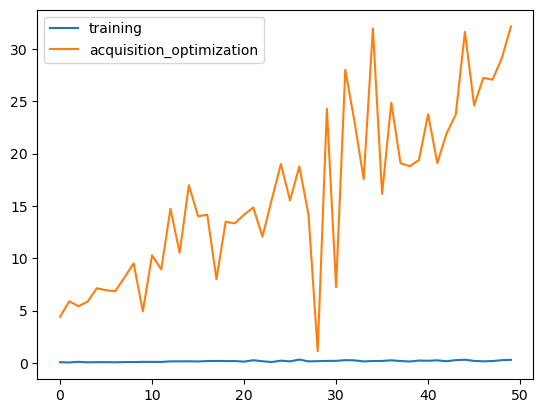

In [14]:
X.generator.computation_time[["training", "acquisition_optimization"]].plot();

In [15]:
# predict optimum
x_optimum = X.generator.get_optimum()
y_optimum = pd.DataFrame(evaluate(x_optimum.to_dict("index")[0], generator=X.generator), index=[0])
y_optimum

,total_size,c1,total_size_prior_mean,total_size_posterior_mean,total_size_posterior_sd,c1_prior_mean,c1_posterior_mean,c1_posterior_sd
0,0.0771,-0.9229,0.04493,0.077119,0.089893,-0.461576,-1.010844,0.187797


In [16]:
# calculate running minimum
running_min = []
for i in range(len(X.data)):
    running_min.append(X.data[vocs.objective_names[0]].iloc[:i+1].min())

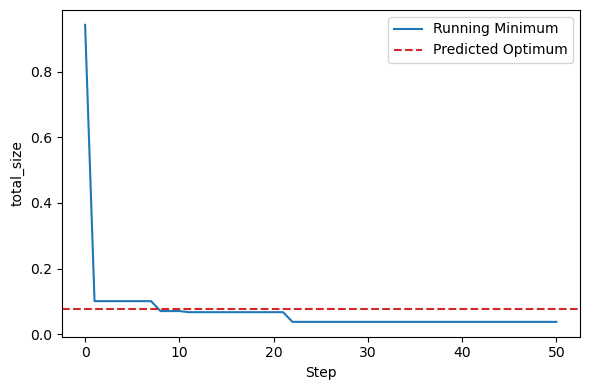

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(torch.arange(n_step + 1), running_min[n_init - 1:], "C0-", label="Running Minimum")
ax.axhline(y=y_optimum[vocs.objective_names[0]][0], color="C3", linestyle="--", label="Predicted Optimum")
ax.set_xlabel("Step")
ax.set_ylabel(f"{vocs.objective_names[0]}")
ax.legend()
fig.tight_layout()

In [18]:
# evaluate output calibration
learned_custom_mean = X.generator.model.models[0].mean_module._model
df = pd.DataFrame(columns=["y_offset", "y_offset_learned", "y_scale", "y_scale_learned"])
for i in range(y_size):
    y_offset = miscal_model.y_offset.detach()[i].item()
    y_offset_learned = torch.nan
    if hasattr(learned_custom_mean, "y_offset"):
        y_offset_learned = -learned_custom_mean.y_offset.detach()[i].item()
    y_scale = miscal_model.y_scale.detach()[i].item()
    y_scale_learned = torch.nan
    if hasattr(learned_custom_mean, "y_scale"):
        y_scale_learned = 1 / learned_custom_mean.y_scale.detach()[i].item()
    df.loc[len(df.index)] = [y_offset, y_offset_learned, y_scale, y_scale_learned]
df

,y_offset,y_offset_learned,y_scale,y_scale_learned
0,-0.5,-0.46783,1.0,NaN


## Display GP model predictions

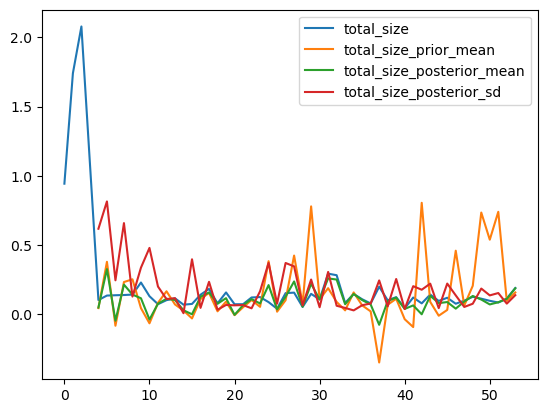

In [19]:
X.data[["total_size" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

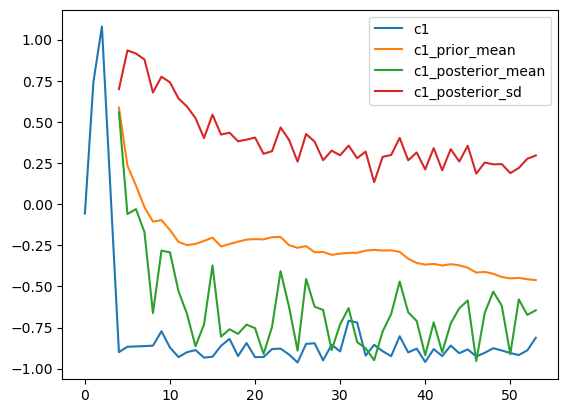

In [20]:
X.data[["c1" + k for k in ["", "_prior_mean", "_posterior_mean", "_posterior_sd"]]].plot();

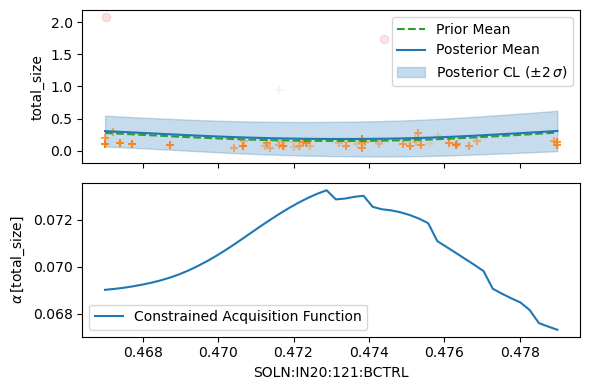

In [21]:
fig, ax = display_model(
    X=X,
    output_name="total_size",
    variable_names=["SOLN:IN20:121:BCTRL"],
)

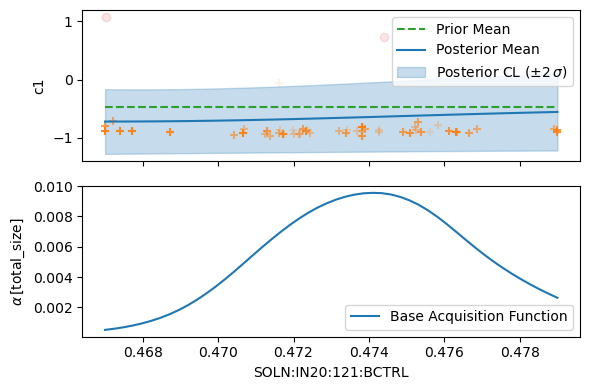

In [22]:
fig, ax = display_model(
    X=X,
    output_name="c1",
    variable_names=["SOLN:IN20:121:BCTRL"],
    constrained_acqf=False,
)